In [60]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import corner
from orbit_class import Orbit
import misc_utils as mu   
import ifs_noise_model as snr_ifs
import imaging_noise_model as snr_im
import juneper_model as hpm  
import hybrid_mcmc 
import coolTLUSTY_model as cpm
import coolT_mcmc 
import simulate_data as simdata 


**Example of setting up a star + planet system**   
These current values are arbitrary choices meant to resemble sun-jupiter, moved in closer to fit in the working angle of the coronagraph. One might instead select values consistent with a known RV planet.

In [22]:
params = {}                    # create a dictionary for your simulation's parameters
params.update({'d_obs':10.0})  # distance to the observer in parsecs
params.update({'Mstar':5.0})   # absolute stellar V-band magnitude
params.update({'Nez':1.0})     # exozodi level
stellartype = 'g0v'            # stellar type
stellar_mass = 1.0             # stellar mass in units of solar mass 
                               # this is only used in orbit object, not really relevant for SNR calculations
stellar_spec = 'AuxiliaryData/'+stellartype+'.dat' # imports Hubble 
ref_wl, ref_flambda = np.loadtxt(stellar_spec, unpack=True, usecols=(0,1))
fstar_lambda = interp1d(ref_wl,ref_flambda)  # specific flux density W / m^2 / micron, for zero mag star
params.update({'fstar_lambda':fstar_lambda}) # a function which returns 
                                             # specific flux density for any wavelength
params.update({'rp':1.0})      # planet radius in Jupiter radii
params.update({'chromo':0.75,'meth':0.25}) # short wavelength (chromophore) and long wavelength (methane)
                                           # weightings for linear combination of Jupiter and Neptune 
params.update({'Ag':hpm.juneper_Agfunc(params['chromo'],params['meth'])}) 
a = 3.8            # semimajor axis (in au)
ecc = 10.0**-8.0   # eccentricity
inc = 90.0         # inclination (degrees)
ome = 90.0         # longitude of ascending node (degrees)
tp = 0.0           # epoch of perihelion passage (julian date)
argperi = 90.0     # argument of perihelion (degrees)
orbit_pars = np.array([ecc,inc,ome,tp,a,argperi,
                       stellar_mass,params['rp'],params['d_obs']])
orbit = Orbit(orbit_pars) 

Now compute self-consistent instantaneous planet-star separation, Phi, and working angle for the desired phase angle, 
phase function, and orbit parameters. Add them to the parameter dictionary with the simdata.change_alpha() function

In [23]:
alpha = 65.0*np.pi/180.0 # phase angle in radians
pfunc = mu.avg_empirical # type of phase function to use
simdata.change_alpha(orbit, params, alpha, pfunc) # updates params['sep'], params['phi'], params['wa']

**Add the desired coronagraph version to your dictionary**  
Note, this also adds needed astronomical/physical constants and some things related to the assumed calibration method. 
The coronagraph/detector options are all hard coded into misc_utils.py :   
 - org_hlc_pars, org_spc_pars  (from before WIETER)
 - cbe_hlc_pars, cbe_spc_pars ("current best estimates" as of August 2018) 
 - req_spc_pars, req_hlc_pars (mission requirements as of August 2018)

In [73]:
params.update(mu.cbe_spc_pars) 

**Now generate some mock IFS data!** 

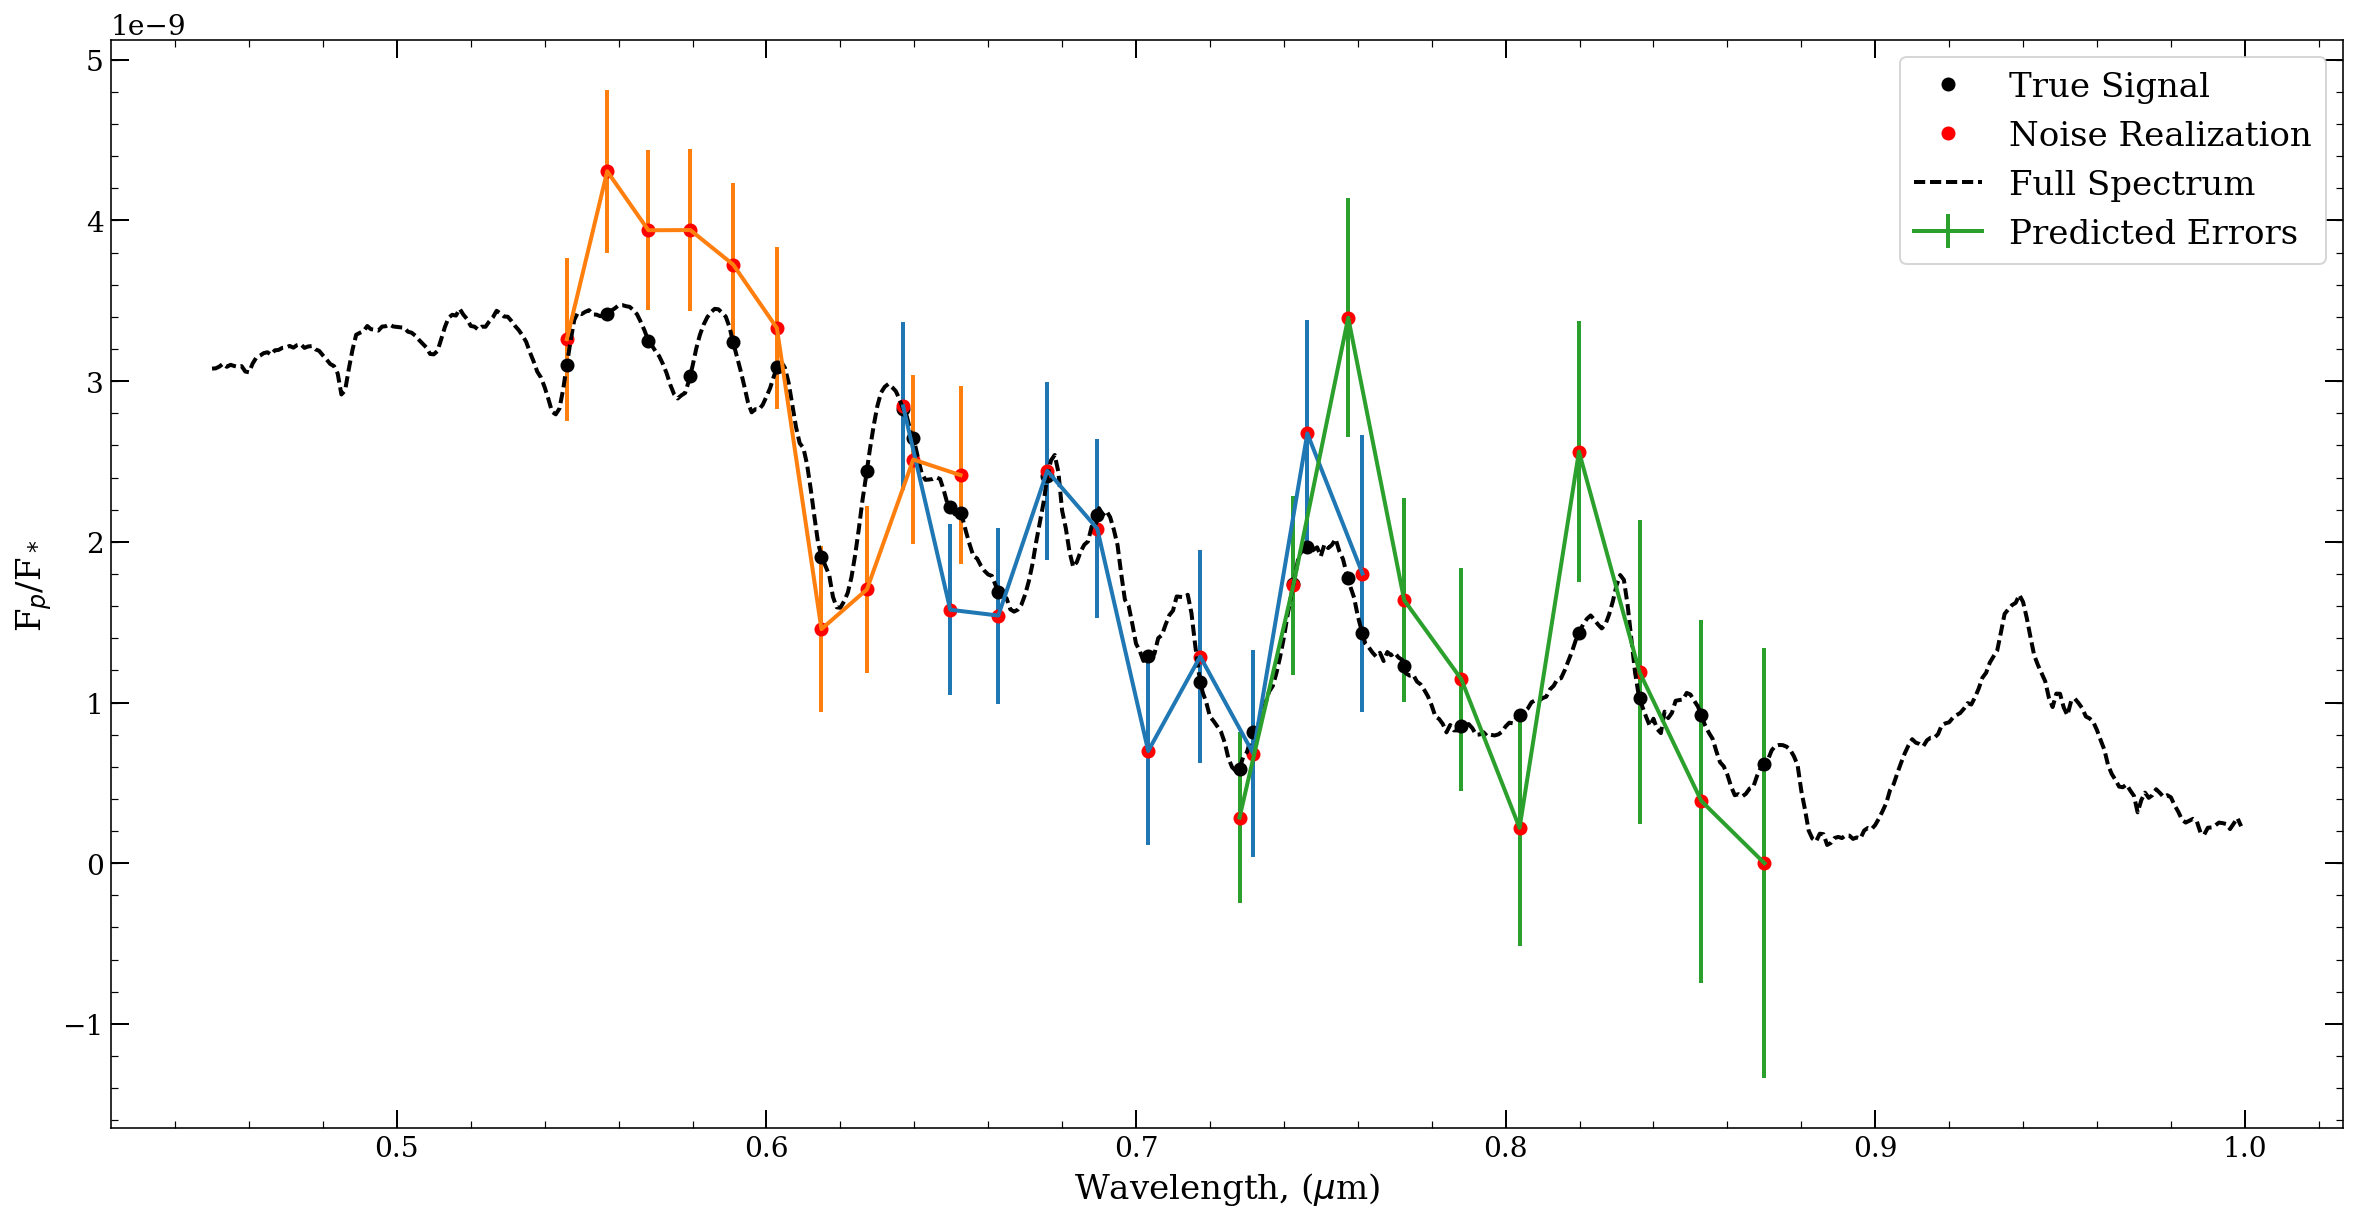

In [76]:
full_wl, full_sig, full_noisy, full_err = np.array([]),np.array([]),np.array([]),np.array([])

TEXP = 300.0        # hours
bandcenter = 0.7    # microns
width = 18.0        # the full width divided by bandcenter * 100.0
wl, truth, random, noise = simdata.generate_noisey_spectra(TEXP, bandcenter, width, params)
plt.figure(figsize=(20,10))
plt.plot(wl,truth,'ko')
plt.plot(wl,random,'ro')
plt.errorbar(wl,random,yerr=noise)
full_wl = np.concatenate((full_wl,wl))
full_sig = np.concatenate((full_sig,truth))
full_noisy = np.concatenate((full_noisy,random))
full_err = np.concatenate((full_err,noise))

TEXP = 300.0       
bandcenter = 0.6    
width = 18.0        
wl, truth, random, noise = simdata.generate_noisey_spectra(TEXP, bandcenter, width, params)
plt.plot(wl,truth,'ko')
plt.plot(wl,random,'ro')
plt.errorbar(wl,random,yerr=noise)
full_wl = np.concatenate((full_wl,wl))
full_sig = np.concatenate((full_sig,truth))
full_noisy = np.concatenate((full_noisy,random))
full_err = np.concatenate((full_err,noise))

TEXP = 500.0       
bandcenter = 0.8    
width = 18.0        
wl, truth, random, noise = simdata.generate_noisey_spectra(TEXP, bandcenter, width, params)
plt.plot(wl,truth,'ko',label='True Signal')
plt.plot(wl,random,'ro',label='Noise Realization')
plt.errorbar(wl,random,yerr=noise, label='Predicted Errors')
plt.plot(np.arange(0.45,1.0,0.001),snr_ifs.planet_star_fluxratio(np.arange(0.45,1.0,0.001), params),
         linestyle='--',color='k', label='Full Spectrum')
full_wl = np.concatenate((full_wl,wl))
full_sig = np.concatenate((full_sig,truth))
full_noisy = np.concatenate((full_noisy,random))
full_err = np.concatenate((full_err,noise))

plt.xlabel('Wavelength, ($\mu$m)',fontsize=17)
plt.ylabel('F$_p$/F$_*$',fontsize=17)
plt.legend(fontsize=17)
plt.show()

**Generate some mock imaging data!**  
NOTE: For use with retrievals, the following imaging band centers and widths are currently hardcoded into juneper_model.py and coolTLUSTY_model.py:   
centers = np.array( [0.506, 0.575, 0.661, 0.721, 0.883, 0.940] )  # these are all in microns  
widths = np.array( [0.103, 0.101, 0.10, 0.050, 0.052, 0.060] )  # these are fractional width/center  
 
To simulate imaging data, one should change the coronagraph to one of the HLC versions.

In [77]:
params.update(mu.cbe_hlc_pars)

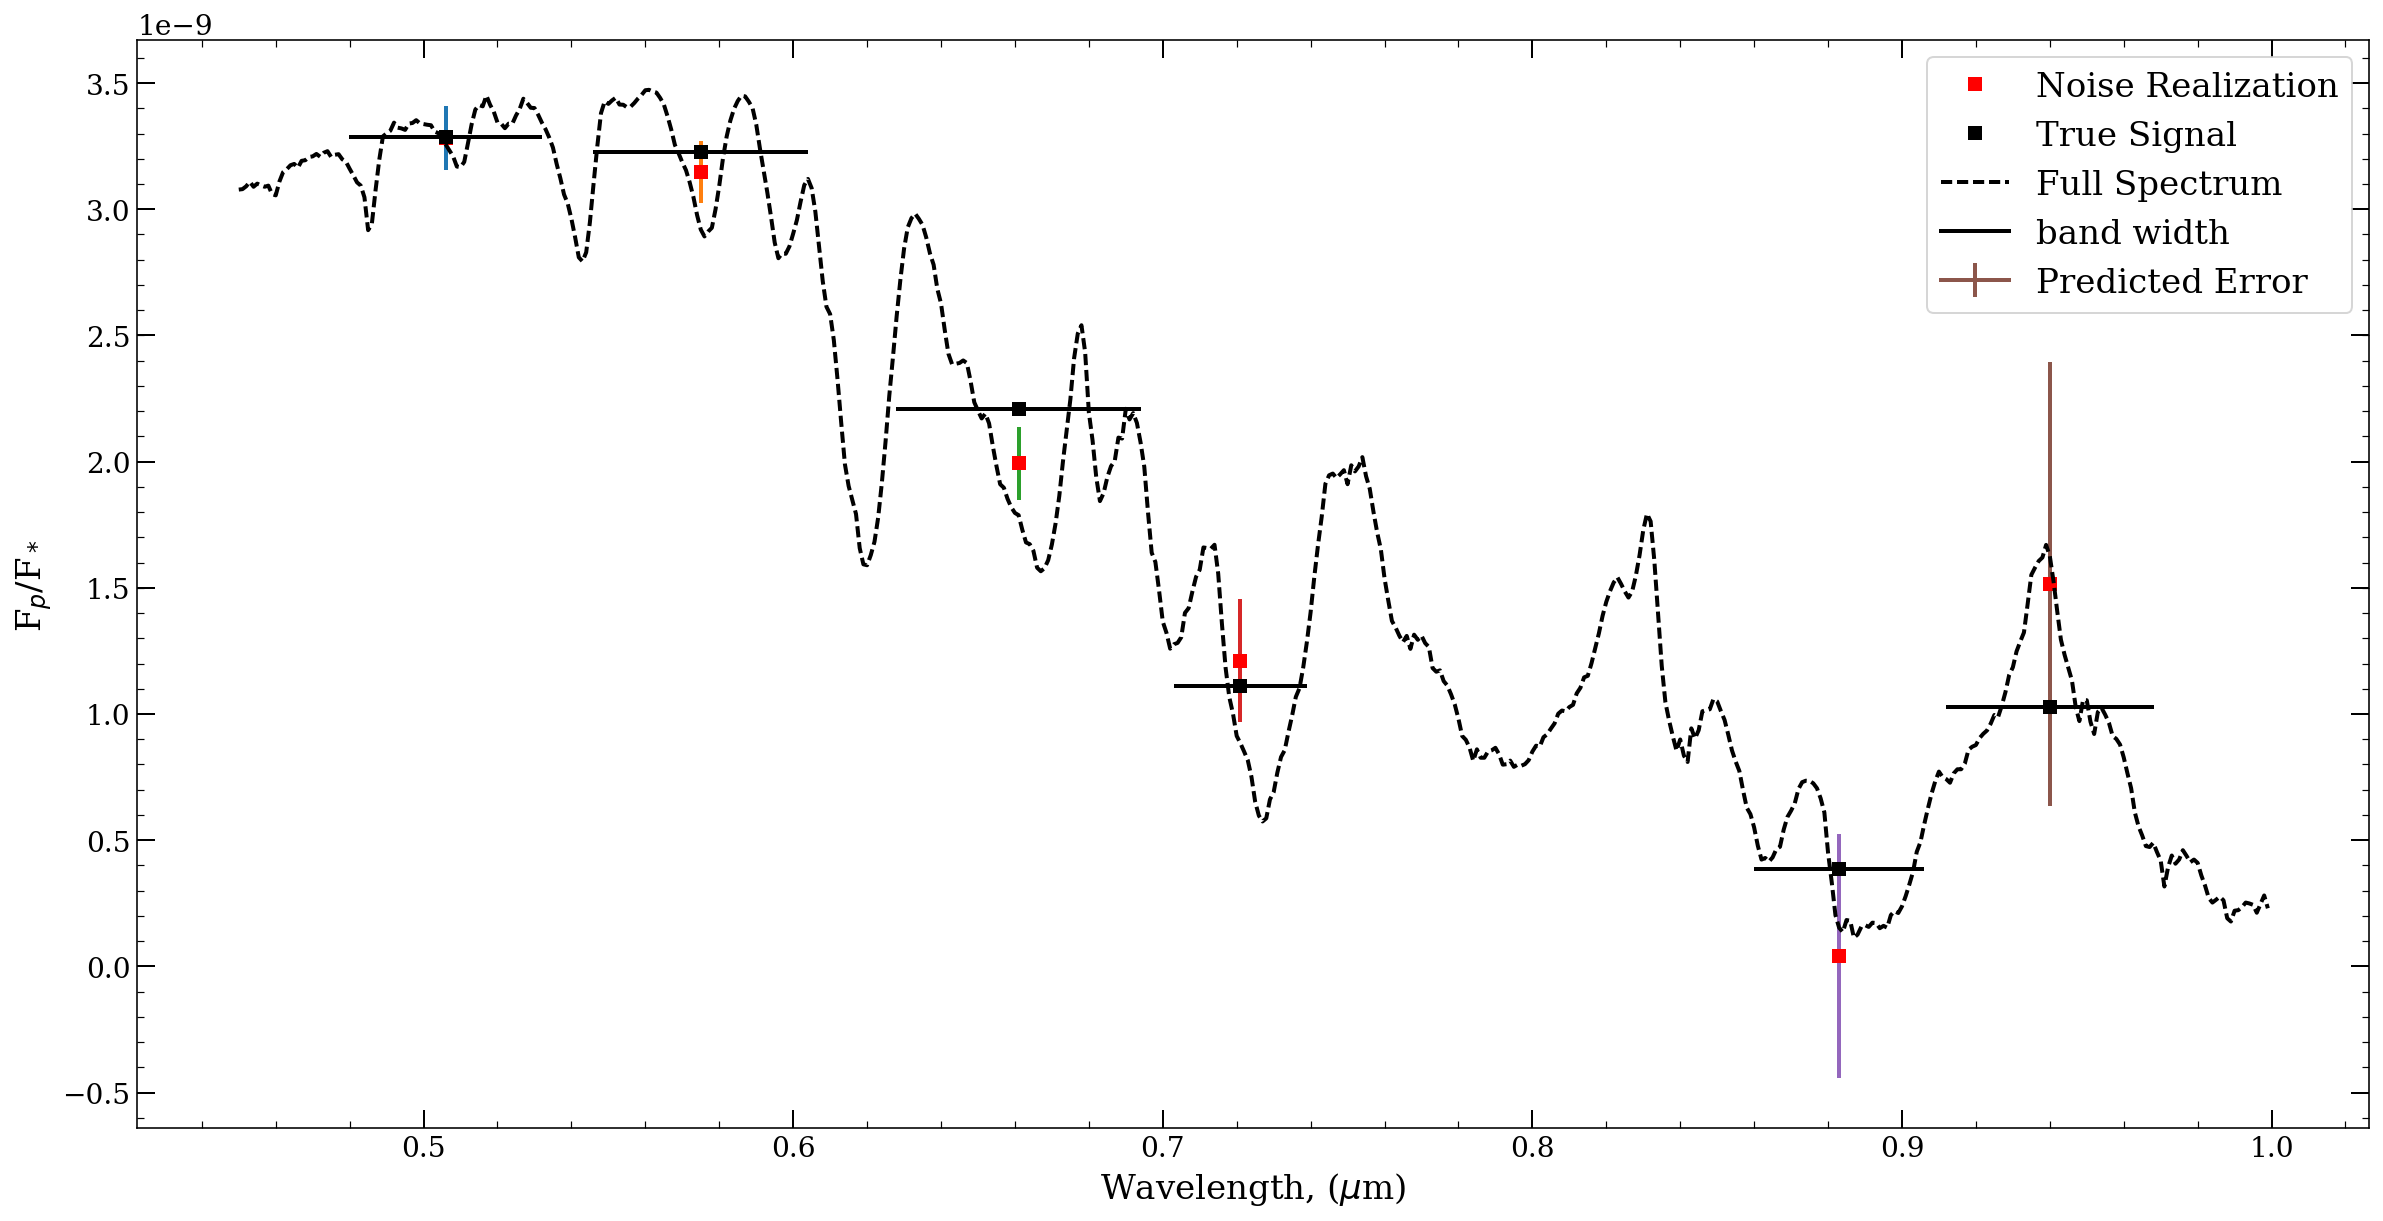

In [78]:
TEXP = 100.0
bandcenter = 0.506
width = 10.3
wl, truth, random, noise = simdata.generate_noisey_imaging(TEXP, bandcenter, width, params)
plt.figure(figsize=(20,10))
plt.errorbar(wl,truth,xerr=bandcenter*width/200.0,color='k')
plt.plot(wl,random,'rs')
plt.plot(wl,truth,'ks')
plt.errorbar(wl,random,yerr=noise)
full_wl = np.concatenate((full_wl,np.array([wl])))
full_sig = np.concatenate((full_sig,np.array([truth])))
full_noisy = np.concatenate((full_noisy,np.array([random])))
full_err = np.concatenate((full_err,np.array([noise])))

TEXP = 100.0
bandcenter = 0.575
width = 10.1
wl, truth, random, noise = simdata.generate_noisey_imaging(TEXP, bandcenter, width, params)
plt.errorbar(wl,truth,xerr=bandcenter*width/200.0,color='k')
plt.plot(wl,random,'rs')
plt.plot(wl,truth,'ks')
plt.errorbar(wl,random,yerr=noise)
full_wl = np.concatenate((full_wl,np.array([wl])))
full_sig = np.concatenate((full_sig,np.array([truth])))
full_noisy = np.concatenate((full_noisy,np.array([random])))
full_err = np.concatenate((full_err,np.array([noise])))

TEXP = 100.0
bandcenter = 0.661
width = 10.0
wl, truth, random, noise = simdata.generate_noisey_imaging(TEXP, bandcenter, width, params)
plt.errorbar(wl,truth,xerr=bandcenter*width/200.0,color='k')
plt.plot(wl,random,'rs')
plt.plot(wl,truth,'ks')
plt.errorbar(wl,random,yerr=noise)
full_wl = np.concatenate((full_wl,np.array([wl])))
full_sig = np.concatenate((full_sig,np.array([truth])))
full_noisy = np.concatenate((full_noisy,np.array([random])))
full_err = np.concatenate((full_err,np.array([noise])))

TEXP = 100.0
bandcenter = 0.721
width = 5.0
wl, truth, random, noise = simdata.generate_noisey_imaging(TEXP, bandcenter, width, params)
plt.errorbar(wl,truth,xerr=bandcenter*width/200.0,color='k')
plt.plot(wl,random,'rs')
plt.plot(wl,truth,'ks')
plt.errorbar(wl,random,yerr=noise)
full_wl = np.concatenate((full_wl,np.array([wl])))
full_sig = np.concatenate((full_sig,np.array([truth])))
full_noisy = np.concatenate((full_noisy,np.array([random])))
full_err = np.concatenate((full_err,np.array([noise])))

TEXP = 300.0
bandcenter = 0.883
width = 5.2
wl, truth, random, noise = simdata.generate_noisey_imaging(TEXP, bandcenter, width, params)
plt.errorbar(wl,truth,xerr=bandcenter*width/200.0,color='k')
plt.plot(wl,random,'rs')
plt.plot(wl,truth,'ks')
plt.errorbar(wl,random,yerr=noise)    
full_wl = np.concatenate((full_wl,np.array([wl])))
full_sig = np.concatenate((full_sig,np.array([truth])))
full_noisy = np.concatenate((full_noisy,np.array([random])))
full_err = np.concatenate((full_err,np.array([noise])))

TEXP = 300.0
bandcenter = 0.940
width = 6.0
wl, truth, random, noise = simdata.generate_noisey_imaging(TEXP, bandcenter, width, params)
plt.errorbar(wl,truth,xerr=bandcenter*width/200.0,color='k',label='band width')
plt.plot(wl,random,'rs',label='Noise Realization')
plt.plot(wl,truth,'ks',label='True Signal')
plt.errorbar(wl,random,yerr=noise,label='Predicted Error')
plt.plot(np.arange(0.45,1.0,0.001),snr_ifs.planet_star_fluxratio(np.arange(0.45,1.0,0.001), params),
         linestyle='--',color='k',label='Full Spectrum')
full_wl = np.concatenate((full_wl,np.array([wl])))
full_sig = np.concatenate((full_sig,np.array([truth])))
full_noisy = np.concatenate((full_noisy,np.array([random])))
full_err = np.concatenate((full_err,np.array([noise])))

plt.xlabel('Wavelength, ($\mu$m)',fontsize=17)
plt.ylabel('F$_p$/F$_*$',fontsize=17)
plt.legend(fontsize=17)
plt.show()


To use the retrieval framework, save your "observations" to a text file in the following form:

First a header with the input parameters 

#sep = 3.8  
#phi = 0.44   
#rp = 1.0  
#meth = 0.25  
#chromo = 0.75  

then four columns of data:  
(1) wavelength in microns  
(2) the true value  
(3) the random noise instance  
(4) the error  

The retrieval runs with column 2 as the data  and with 4 as the corresponding error bars. You could choose to reverse columns 2 and 3 if you want to fit your random noise instance instead of the true values.

In [42]:
headerstring = simdata.create_header_string(-999, params)
sorted_mask = np.argsort(full_wl)
wl = full_wl[sorted_mask]
truth = full_sig[sorted_mask]
rand = full_noisy[sorted_mask]
err = full_err[sorted_mask]
np.savetxt('mock_obs.dat',np.array([wl,truth,rand,err]).T,header=headerstring)

Now use emcee to run a retrieval. The mcmc chain parameters are hard coded into hybrid_mcmc.py and coolT_mcmc.py.

In [ ]:
#samples = hybrid_mcmc.run_mcmc('mock_obs.dat')
samples = np.loadtxt('mock_obs.dat._chain.dat',unpack=True)

Take a look at the results

In [71]:
ndim, nsteps = samples.shape
labels =['p$_c$','p$_m$','r$_p$'] 
truths = np.array([0.75,0.25,1.0])
medians = np.median(samples,axis=1) 
stdvs = np.std(samples,axis=1)
upper_sig = np.percentile(samples,84,axis=1)
lower_sig = np.percentile(samples,16,axis=1)
for k in range(ndim):
    print(labels[k], medians[k], stdvs[k], lower_sig[k], upper_sig[k],'\n')

p$_c$ 0.755049474681 0.156218697031 0.577938441691 0.902834070876 

p$_m$ 0.274670713683 0.0501443155683 0.225475280555 0.324753737354 

r$_p$ 0.993853565574 0.012402418053 0.981636762856 1.0062703075 



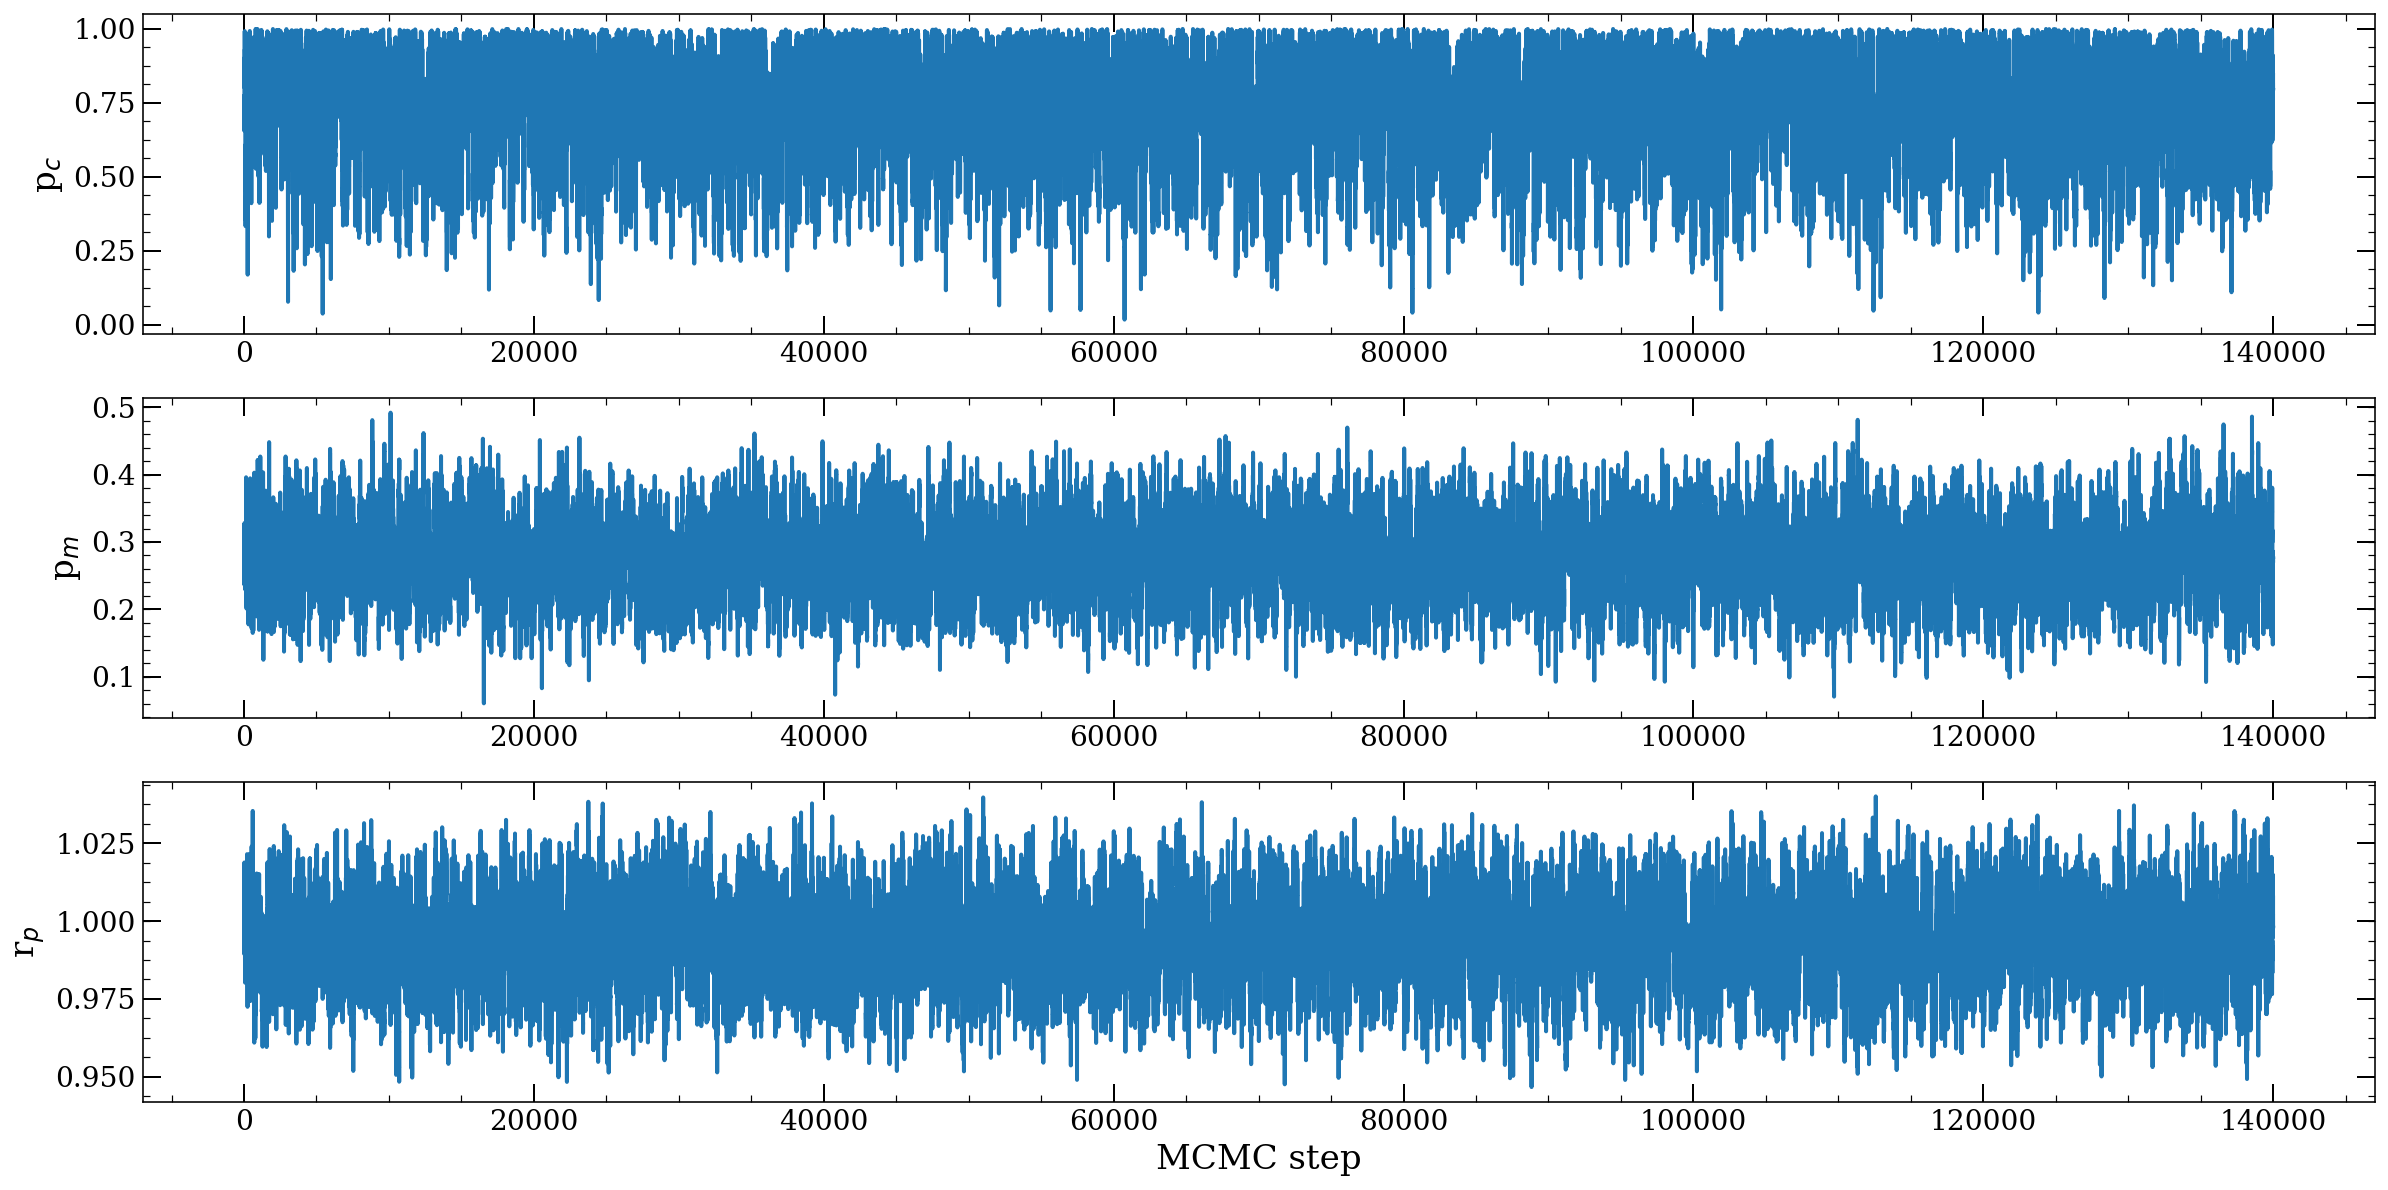

In [69]:
plt.figure(figsize=(20,10))
for k in range(ndim):
    plt.subplot(ndim,1,k+1)
    plt.plot(range(nsteps),samples[k,:])
    plt.ylabel(labels[k],fontsize=17)
        
plt.xlabel("MCMC step",fontsize=17)
plt.savefig("mock_obs_walker_plot.png")

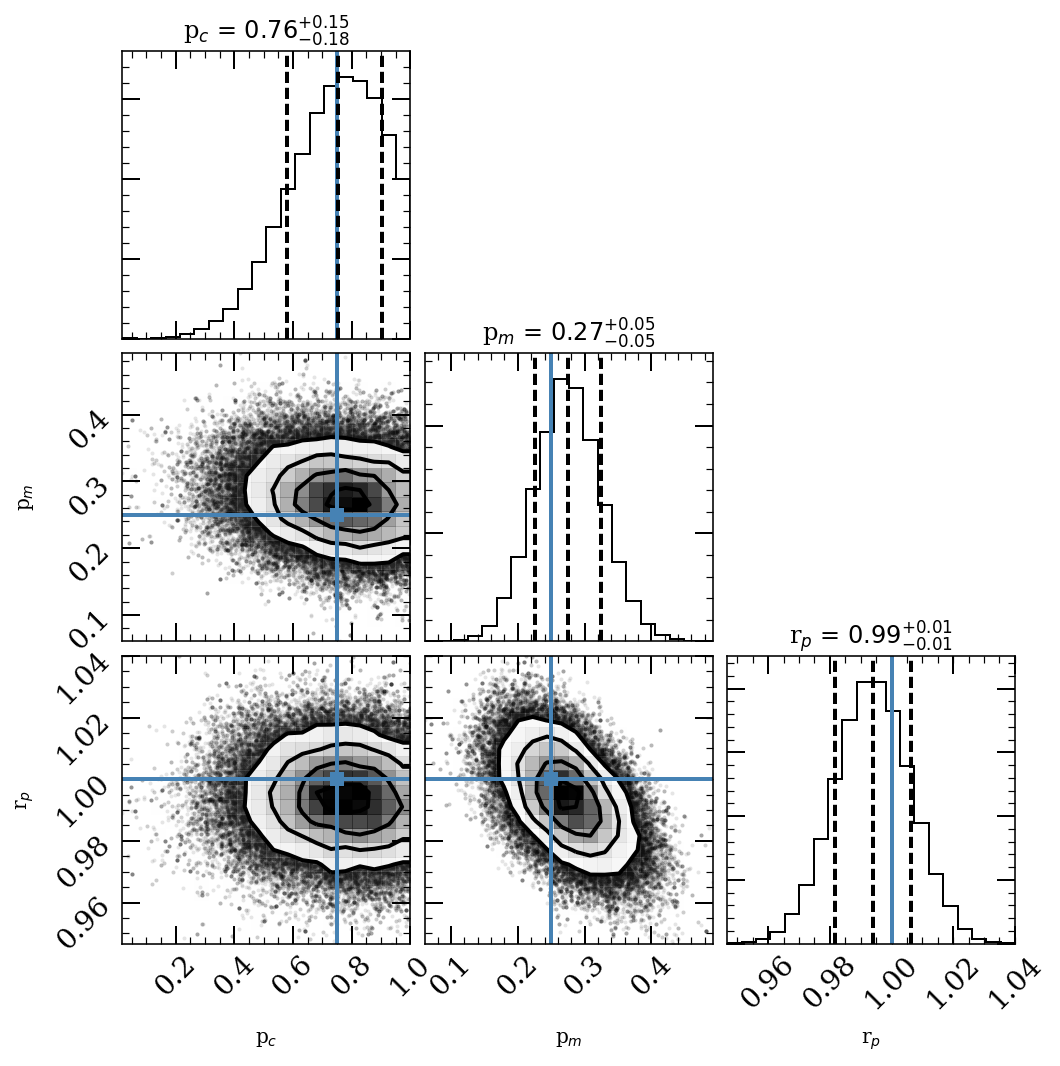

In [81]:
fig = corner.corner(samples.T, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True)
fig.savefig("mock_obs_triangle.png") 